# Intro

Die hier bereitgestellte Library wurde zur Unterstützung der im beigelegten Projektbericht beschriebenen Experimente erstellt. Der Projektbericht befindet sich in 

>  **docs/Projektbericht.pdf** 

und stellt das Forschungsziel, Vorgehen und Ergebnisse auf
theoretischer und fachlicher Ebene dar. Es bietet sich an zunächst den Forschungsbericht unter die Lupe zu nehmen, um
das **Why**, **What** und **How** der hier dargestellten Codebeispiele besser verstehen zu können.

Die bereitgestellten Notebooks dienen als Einführung in die praktische Arbeit mit astronomischen Dateiformaten und dabei
 speziell der Vorverarbeitung von astronomischen Bilddaten, um diese mithilfe der Implementierung von PINK, des parallelisierten 
rotations- und flipinvarianten Self-Organizing Map Algorithmus, verarbeiten zu lassen.

## FITs

Im Rahmen dieses Projekts wurden FITS-Bilddateien des Lofar Two Metre Sky Surveys (LoTSS) Data Release 1 (Bilddateien im Radiospektrum) sowie
Bilddateien des Pan-STARR Data Releases (optische Bilddateien) sowie die zugehörigen FITS-Katalogdateien verwendet.

> LoTSS - Data Release 1: https://lofar-surveys.org/releases.html
> Pan-STARRS1 - Data Archive: https://panstarrs.stsci.edu/

Zum Einlesen der FITs-Bild- und Tabellendateien wurde die astronomische Python-Library `astropy` verwendet.

Es bietet sich an, sich in die Dokumentation der Library einzulesen

https://docs.astropy.org/en/stable/index.html

und hierbei speziell den Teil zur Verarbeitung von FITs-Dateien zu
beachten:

https://docs.astropy.org/en/stable/io/fits/index.html


# PINK

PINK ist ein in C++ entwickeltes Programm, mit dem sich
Self-Organizing Maps auf einer GPU trainieren lassen. 
PINK erwartet ein spezielles binäres Dateiformat und
erstellt durch das Training und Mapping widerum spezielle
binäre SOM- und Map-Dateiformate.

Es handelt sich bei den Binärdateien um relativ einfache Formate im row-major Layout. Im offizellen Repository findet sich eine Beschreibung der Dateiformate [FILE_FORMATS.md](https://github.com/HITS-AIN/PINK/blob/master/FILE_FORMATS.md).

## 2. `.pink` - Bilddateien

Diese Dateien beinhalten mehrere Bilder mit Dimensionen `(channel x height x width)`. Im Fileheader finden sich Informationen zu den verschiedenen Parametern.

### 2.2 Header

```python
# <file format version> 0 <data-type> <number of entries> <data layout> <data>
 (
   version,                 # 1 / 2
   file_type,               # 0 (PINK-File)/(Image-File)
   data_type,               # 0 (32 bit floats)
   number_of_entries        # number of images
   layout,                  # 0 (box) / 1 (hex)
   dimensionality,          # 1, 2, 3, .. -> 1D, 2D, 3D, ..
 ) = struct.unpack('i' * 6, inputStream.read(4 * 6))

numberOfChannels = struct.unpack('i', file.read(4))[0] if dimensionality > 2 else 1
height           = struct.unpack('i', file.read(4))[0] if dimensionality > 1 else 1
width            = struct.unpack('i', file.read(4))[0]
```

### 2.2 Body / Daten

Die Daten in Row-Major Ordnung gespeichert (siehe Abschnitt 1.1 für Erklärung)

[FILE_FORMATS.md](https://github.com/HITS-AIN/PINK/blob/master/FILE_FORMATS.md) im PINK-Repo:

> The data layout is row-major (C-style), which means that the strides grow from right to left.

## 3. `.som` - Self-Organizing Map Ergebnisdateien

### 3.1 Header

```python
# <file format version> 1 <data-type> <number of entries> <som layout> <data>
 (
   version,                 # 1 / 2
   file_type,               # 1 (SOM-File)
   data_type,               # 0 (32 bit floats)
   som_layout,              # 0 (box) / 1 (hex)
   som_dimensionality,      # 1, 2, 3, .. -> 1D, 2D, 3D, ..
#    Hier abhängig von som_dimensionality    -> (som_depth, som_height, som_width) in dieser Abfolge   
   neuron_layout,            # 0 (box) / 1 (hex)
   neuron_dimensionality    # 1, 2, 3 -> 1D, 2D, 3D
#    Hier abhängig von neuron_dimensionality -> (neuron_channels, neuron_height, neuron_width)
 )
```

Auslesen in Code folgendermaßen:

```python
# SOM-Parameter
version, file_type, data_type, som_layout, som_dimensionality = struct.unpack('i' * 5, inputStream.read(4 * 5))
somDepth = struct.unpack('i', inputStream.read(4))[0] if som_dimensionality > 2 else 1
somHeight = struct.unpack('i', inputStream.read(4))[0] if som_dimensionality > 1 else 1
somWidth = struct.unpack('i', inputStream.read(4))[0]

# Neuronen-Parameter
neuron_layout, neuron_dimensionality = struct.unpack('i' * 2, inputStream.read(4 * 2))
numberOfChannels = struct.unpack('i', inputStream.read(4))[0] if neuron_dimensionality > 2 else 1
neuronHeight = struct.unpack('i', inputStream.read(4))[0] if neuron_dimensionality > 1 else 1
neuronWidth = struct.unpack('i', inputStream.read(4))[0]
```

<https://github.com/HITS-AIN/PINK/blob/master/scripts/show_som.py>

### 3.2 Body / Daten

Einlesen der Daten wird mit folgendem Loop durchgeführt:

```python
while True:
    data = numpy.ones(self.__neuronWidth * self.__neuronHeight * self.__numberOfChannels)
    for i in range(self.__neuronWidth * self.__neuronHeight * self.__numberOfChannels):
        data[i] = struct.unpack_from("f", inputStream.read(4))[0]
    self.__neurons.append(data)
```

Für jeden Knoten / Neuron wird also ein Vektor der Größe `neuron_channels x neuron_height x neuron_width` ausgelesen.

Zum Anzeigen wird die `calculate_map`-Funktion verwendet.

Wie unter Abschnitt 1.1 beschrieben, handelt es sich auch bei den Gewichten der SOM-Neuronen um Floating-Point Werte im Column-Major / Fortran Layout.

## 4. `.map` - Image-zu-Knoten Mapping Dateien

Eine `.map`-Datei beinhaltet das Mapping / die Aktivierung der SOM-Output-Knoten / Weights einer trainierten SOM (in einer `.som`-Datei) für alle eingegebenen Inputbilder (in einer `pink`-Datei).

Das Mapping / die Aktivierung entspricht dabei der Distanz zwischen jeweiligem Input und Output-Knoten und hängt von der bei der Parametrisierung des SOMs gewählten Distanzfunktion ab (default: euklidischer Abstand).

### 4.1 Header

```python
# <file format version> 2 <data-type> <number of entries> <som layout> <data>
 (
   version,                 # 1 / 2
   file_type,               # 2 (Map-File)
   data_type,               # 0 (32 bit floats)
   number_of_data_entries,  # == number_of_images
   som_layout,              # 0 (box) / 1 (hex)
   som_dimensionality       # 1, 2, 3, .. -> 1D, 2D, 3D, ..
 ) = struct.unpack('i' * 6, inputStream.read(4 * 6))
```

SOM-Dimensionality wird hierbei in umgekehrter Reihenfolge ausgelesen / beschrieben als dies bei den `.pink` und `.som`-Files der Fall ist:

```python
numberOfImages = number_of_data_entries
somWidth       = som_dimensions[0]
somHeight      = som_dimensions[1] if som_dimensionality > 1 else 1
somDepth       = som_dimensions[2] if som_dimensionality > 2 else 1
```

Im File-Header taucht also bei Dimensionalität > 1 zunächst die Breite, dann die Höhe und dann die Tiefe des SOM-Layouts auf.

<https://github.com/HITS-AIN/PINK/blob/master/scripts/show_heatmap.py>

### 4.2 Body / Daten

Bei 4 Inputbildern und einem SOM mit einem Gitter aus 10x10 (=100) Neuronen werden insgesamt $`4 \cdot 10 \cdot 10 = 400`$ Floating-Point Werte in den Body der Datei geschrieben.

Jeder Eintrag entspricht hierbei der Distanz zwischen jeweiligem Inputbild und einem Output-Knoten. Je kürzer die Distanz, desto besser mappt das Inputbild auf den Output-Knoten.

Die Floating-Point-Werte sind hierbei zunächst nach Image sortiert dh. bei den oben beschriebenen Dimensionen entsprechen die ersten 100 Floating Point-Werte den Distanzen zwischen dem ersten Bild und den 100 Output-Knoten.

Die 100 FP-Werte (Distanzen / Aktivierungen) eines Bildes sind in Column-Major Layout gespeichert, was man an folgendem Codeausschnitt erkennen kann.

```python
for x in range(somWidth):
  for y in range(somHeight):
    data = neurons[y + x*somHeight]
#    data = np.ones((neuronWidth, neuronHeight)) * neurons[y + x*somHeight]
```

<https://github.com/HITS-AIN/PINK/blob/22b086d44a1101c90850a1195b0c937349283df2/scripts/tools.py#L74>

> Die auskommentierte Numpy-Matrix mit Dimension `neuronWidth x neuronHeight` wird in dieser Form für die Heatmap verwendet und gibt die Größe des farbigen Rechtecks vor.
>
> <https://github.com/HITS-AIN/PINK/blob/22b086d44a1101c90850a1195b0c937349283df2/scripts/show_heatmap.py#L101>

Der äußere (langsame) Loop wählt eine Spalte aus und der innere Loop iteriert über dessen Einträge. Es wird also von oben-nach-unten und dann erst von links-nach-rechts iteriert. Dies ist Standard in Fortran. In C wird typischerweise das Row-Major Layout verwendet und dabei Zeile für Zeile beschrieben / gelesen.

### Reference

_FILE_FORMATS.md_:

<https://github.com/HITS-AIN/PINK/blob/master/FILE_FORMATS.md># 1. File-Formate



# hda_fits

Die Library kann mit folgendem Shellbefehl im aktuellen Python-Environment installiert werden.

```sh
pip install .
```

Die Library beinhaltet mehrere Module unterschiedlicher Funktionalität.


* fits.py - Low-Level Funktionen zur Handhabe von FITs-Dateien
* image_processing.py - Numpymatrix / Bild(vor)verarbeitungsfunktionen
* map.py - Funktionen die PINK-Mapdateien betreffen
* panstarrs.py - Funktion zum Beziehen der optischen Panstarrsbilddaten
* pink.py - Funktionen zur Verarbeitung und erzeugung von PINK-Binärdateien
* sdss.py - Funktionen zum Beziehen von optischen Bilddaten aus dem SDSS-Katalog
* som.py - Funktionen zum Einlesen von SOM - Binärdateien
* types.py - Typdefinitionen
* visualization.py - Visualisierungsfunktionen für SOMs, Maps und PINK-Dateien

In [1]:
# Handhabe der FITs-Dateien
from hda_fits import fits as hfits

# Handhabe der PINK-Dateien
from hda_fits import pink as hpink

## FITs - Bild und Katalogdateien

Als wichtigste Grundlage dient der Shimwell Data Release 1 Katalog. Dieser beinhaltet die astronomischen Koordinaten Rechtsaszension (RA) und Deklination (DEC) von über 300000 Radiogalaxien.
Mithilfe dieser Koordinaten und der Mosaic-Bilddateien des LoTSS - Data Release, können Bildausschnitte der Himmelsobjekte gewonnen und in eine PINK-Binärdatei überführt werden.

Hierzu wird zunächst der Shimwellkatalog geladen

In [11]:
# Download des Shimwell-Katalogs
#hfits.download_shimwell_catalog("../data/")

# Einlesen des Katalogs als Pandas-DataFrame
cat = hfits.read_shimwell_catalog("../data/LOFAR_HBA_T1_DR1_catalog_v1.0.srl.fits")
cat

,Source_Name,RA,E_RA,E_RA_tot,DEC,E_DEC,E_DEC_tot,Peak_flux,E_Peak_flux,E_Peak_flux_tot,...,DC_Min,E_DC_Min,PA,E_PA,DC_PA,E_DC_PA,Isl_rms,S_Code,Mosaic_ID,Isl_id
0,ILTJ122108.44+491340.9,185.285169,0.085070,0.150016,49.228040,0.094025,0.155269,1.487188,0.052545,0.302043,...,0.000000,0.191653,153.935376,18.490889,0.000000,18.490889,0.052946,S,P22Hetdex04,188
1,ILTJ122107.85+491951.8,185.282711,0.473938,0.489781,49.331069,0.474978,0.490787,0.494207,0.065855,0.118771,...,3.133429,0.807971,46.459300,23.108515,46.459300,23.108515,0.061683,S,P22Hetdex04,196
2,ILTJ122108.57+493121.9,185.285716,0.533848,0.547961,49.522749,0.367264,0.387493,0.357484,0.053257,0.089152,...,0.000000,0.732001,67.376946,23.852980,67.376946,23.852980,0.051969,S,P22Hetdex04,202
3,ILTJ122104.03+490823.8,185.266779,0.068061,0.141068,49.139945,0.068960,0.141504,2.185012,0.056130,0.440592,...,1.742156,0.159759,158.418653,107.214019,158.418653,107.214019,0.054956,S,P22Hetdex04,204
4,ILTJ122105.03+491440.0,185.270960,0.585020,0.597927,49.244449,0.508483,0.523281,0.291824,0.055295,0.080399,...,0.000000,1.033656,125.162792,44.793405,125.162792,44.793405,0.053522,S,P22Hetdex04,205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325689,ILTJ134632.30+485421.1,206.634589,6.090501,6.092620,48.905884,8.203237,8.204811,0.059738,0.019692,0.023033,...,42.220979,13.994056,166.429974,55.220061,166.429974,55.220061,0.059567,S,P206+50,9965
325690,ILTJ134454.66+491951.3,206.227760,8.719767,8.721248,49.330923,10.094966,10.096245,0.057878,0.025266,0.027792,...,36.001837,15.796325,35.864871,53.397979,35.864871,53.397979,0.072564,S,P206+50,9967
325691,ILTJ134426.19+492250.8,206.109105,7.353377,7.355133,49.380788,8.146333,8.147918,0.064659,0.021652,0.025220,...,48.610323,16.361624,28.837174,82.745069,28.837174,82.745069,0.070229,S,P206+50,9968
325692,ILTJ134416.18+484518.6,206.067406,4.279048,4.282065,48.755176,2.351016,2.356502,0.197491,0.024090,0.046265,...,41.779683,5.110296,103.056935,12.449204,103.056935,12.449204,0.086023,S,P206+50,9970


Der Shimwellkatalog kann daraufhin mithilfe typischer Pandas-Funktionen auf die interessierenden Objekte gefiltert werden.

In [13]:
cat_subset = cat[cat["S_Code"] == "C"].head(5)
cat_subset.head(5)

,Source_Name,RA,E_RA,E_RA_tot,DEC,E_DEC,E_DEC_tot,Peak_flux,E_Peak_flux,E_Peak_flux_tot,...,DC_Min,E_DC_Min,PA,E_PA,DC_PA,E_DC_PA,Isl_rms,S_Code,Mosaic_ID,Isl_id
4054,ILTJ120800.39+495607.9,182.001646,0.013954,0.124349,49.935548,0.014009,0.124355,19.182606,0.101341,3.837859,...,1.638332,0.032797,149.722174,54.109835,149.722174,54.109835,0.099546,C,P22Hetdex04,5006
7621,ILTJ111100.50+521444.3,167.752075,0.021597,0.174373,52.245640,0.015568,0.173730,17.045323,0.102154,3.410595,...,2.662402,0.036482,95.356292,1.018058,95.356292,1.018058,0.096193,C,P8Hetdex,3935
7622,ILTJ111058.20+521444.3,167.742506,0.063235,0.184223,52.245660,0.044029,0.178545,6.260779,0.102967,1.256382,...,3.219402,0.103381,93.733257,3.184735,93.733257,3.184735,0.096193,C,P8Hetdex,3935
18022,ILTJ121215.29+533054.9,183.063689,0.049877,0.134335,53.515269,0.030321,0.128365,7.722341,0.087457,1.546942,...,3.490728,0.070651,84.203569,2.229824,84.203569,2.229824,0.081719,C,P182+55,2592
18023,ILTJ121213.83+533055.7,183.057642,0.049263,0.134109,53.515487,0.035989,0.129821,7.160457,0.087946,1.434789,...,3.828152,0.080531,107.892602,2.909930,107.892602,2.909930,0.081719,C,P182+55,2592


Mit der in `pink.py` bereitgestellten Funktionalität kann aus den Mosaicdateien und Shimwell-Katalogausschnitt eine (Single-Channel)-Pinkdatei mit Radiogalaxien erstellt werden.
Hierzu nutzt man die Funktion `write_catalog_objects_pink_file_v2`

In [29]:
catalog_written = hpink.write_catalog_objects_pink_file_v2(
    filepath="data/my_pink_file_radio.pink",                      # Name des zu erzeugenden PINK-Files  
    catalog=cat_subset,                                     # Shimwell-Katalog-Subset mit Objektkoordinaten
    mosaic_path="../../eda_repos/dennis-eda/data/mosaics/", # Pfad zu lokal gespeicherten Mosaic-Dateien
    download=True,                                          # Wenn Mosaic-Dateien nicht vorhanden, sollen diese heruntergeladen werden?
    image_size=95,                                          # Größe des Bildausschnitts: Hier 95x95 Pixel
    )
catalog_written.to_parquet("data/my_written_catalog_radio.parquet")


2022-02-04 22:54:41,321 pink.py: Going to write 5 images
2022-02-04 22:54:41,325 fits.py: Loading ../../eda_repos/dennis-eda/data/mosaics/P22Hetdex04-mosaic.fits
2022-02-04 22:54:41,343 pink.py: Wrote 1 images to data/my_pink_file_radio.pink
2022-02-04 22:54:41,346 fits.py: Loading ../../eda_repos/dennis-eda/data/mosaics/P8Hetdex-mosaic.fits
2022-02-04 22:54:41,365 pink.py: Wrote 2 images to data/my_pink_file_radio.pink
2022-02-04 22:54:41,370 fits.py: Loading ../../eda_repos/dennis-eda/data/mosaics/P182+55-mosaic.fits
2022-02-04 22:54:41,390 pink.py: Wrote 2 images to data/my_pink_file_radio.pink
2022-02-04 22:54:41,397 pink.py: Wrote 5 images to data/my_pink_file_radio.pink.


Der Katalog aus dem Rückgabewert zeigt auf, welche und wieviele der Bilder geschrieben werden konnten.
Ab und an kann ein Bild aufgrund von NaNs nicht in das PINK-File geschireben werden (oder man setzt explizit "fill_nan", um die missing values zu überschreiben).


In [15]:
print(catalog_written.shape)
catalog_written.head(5)

(5, 29)


,Source_Name,RA,E_RA,E_RA_tot,DEC,E_DEC,E_DEC_tot,Peak_flux,E_Peak_flux,E_Peak_flux_tot,...,DC_Min,E_DC_Min,PA,E_PA,DC_PA,E_DC_PA,Isl_rms,S_Code,Mosaic_ID,Isl_id
4054,ILTJ120800.39+495607.9,182.001646,0.013954,0.124349,49.935548,0.014009,0.124355,19.182606,0.101341,3.837859,...,1.638332,0.032797,149.722174,54.109835,149.722174,54.109835,0.099546,C,P22Hetdex04,5006
7621,ILTJ111100.50+521444.3,167.752075,0.021597,0.174373,52.245640,0.015568,0.173730,17.045323,0.102154,3.410595,...,2.662402,0.036482,95.356292,1.018058,95.356292,1.018058,0.096193,C,P8Hetdex,3935
7622,ILTJ111058.20+521444.3,167.742506,0.063235,0.184223,52.245660,0.044029,0.178545,6.260779,0.102967,1.256382,...,3.219402,0.103381,93.733257,3.184735,93.733257,3.184735,0.096193,C,P8Hetdex,3935
18022,ILTJ121215.29+533054.9,183.063689,0.049877,0.134335,53.515269,0.030321,0.128365,7.722341,0.087457,1.546942,...,3.490728,0.070651,84.203569,2.229824,84.203569,2.229824,0.081719,C,P182+55,2592
18023,ILTJ121213.83+533055.7,183.057642,0.049263,0.134109,53.515487,0.035989,0.129821,7.160457,0.087946,1.434789,...,3.828152,0.080531,107.892602,2.909930,107.892602,2.909930,0.081719,C,P182+55,2592


Das erzeugte PINK-File lässt sich nun mit den Funktionen aus `pink.py` einlesen und mit den Funktionen aus `visualization.py` grafisch darstellen.

In [16]:
# Headerinformationen einlesen
hpink.read_pink_file_header("data/my_pink_file_radio.pink")


PinkHeader(version=2, file_type=0, data_type=0, number_of_images=5, data_layout=0, dimensionality=2, layout=Layout(width=95, height=95, depth=1), header_end_offset=32)

In [17]:
# Bilddaten / Numpyarray des Bildes an Offset 1 lesen
hpink.read_pink_file_image("data/my_pink_file_radio.pink", 1)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

(<Figure size 1728x576 with 1 Axes>, <AxesSubplot:>)

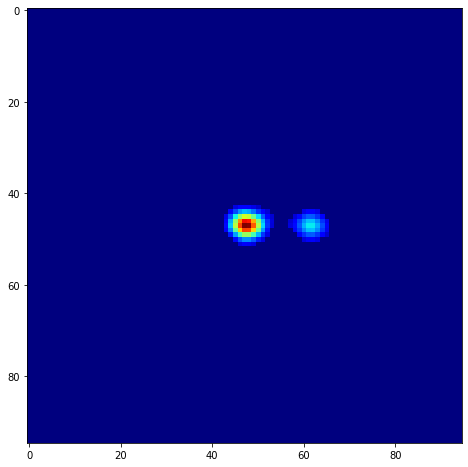

In [18]:
# Visualisierung des Bildes an Offset 1
from hda_fits import visualization as hvis

hvis.show_image("data/my_pink_file_radio.pink", 1)

# SOM und Map

Das erzeugte PINK-File kann nun auch zum Training mit der PINK-Executable verwendet werden indem man die PINK-Executable mit folgenden Parametern startet:

```sh
/PATH/TO/Pink --train data/my_pink_file.pink data/my_trained_som.som 
```

Das PINK-File und aus diesem erzeugte SOM-File kann nun zur Erzeugung des Map-Files, dass die euklidischen Distanzen jedes Bildes zu jedem SOM-Knoten enthält, verwendet werden.

```sh
/PATH/TO/Pink --map data/my_pink_file.pink data/my_map_file.map data/my_trained_som.som 
```

Weitere Informationen zur Nutzung der PINK-Applikation finden sich im offizellen Repository:

https://github.com/HITS-AIN/PINK

## SOM

Ein trainiertes SOM kann mithilfe der SOM-Klasse geladen und inspiziert werden. Weiterhin lässt sich die SOM mithilfe der in `visualization.py` bereitgestellten Funktionen visualisieren.

In [19]:
from hda_fits import som as hsom

# Einlesen des SOM-Files als SOM-Klasseninstanz
som = hsom.read_som("data/my_trained_som.som")
som.header

SOMHeader(version=2, file_type=1, data_type=0, data_layout=0, som_dimensionality=2, som_layout=Layout(width=10, height=10, depth=1), neuron_dimensionality=2, neuron_layout=Layout(width=135, height=135, depth=1), header_end_offset=44)

In [20]:
# Auslesen des SOM-Knotens an Index (2, 3) im 10x10 Gitter
som.get_node(2,3)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

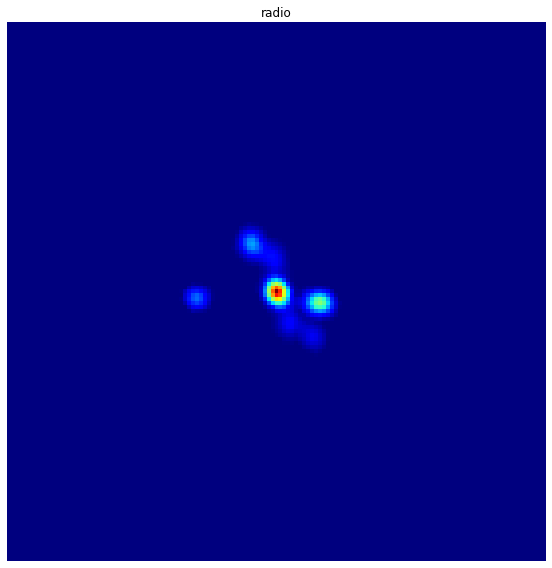

In [21]:
# Grafische Darstellung des Knotens an Index (2,3)
fig, ax = hvis.show_som_node(som, 2,3)

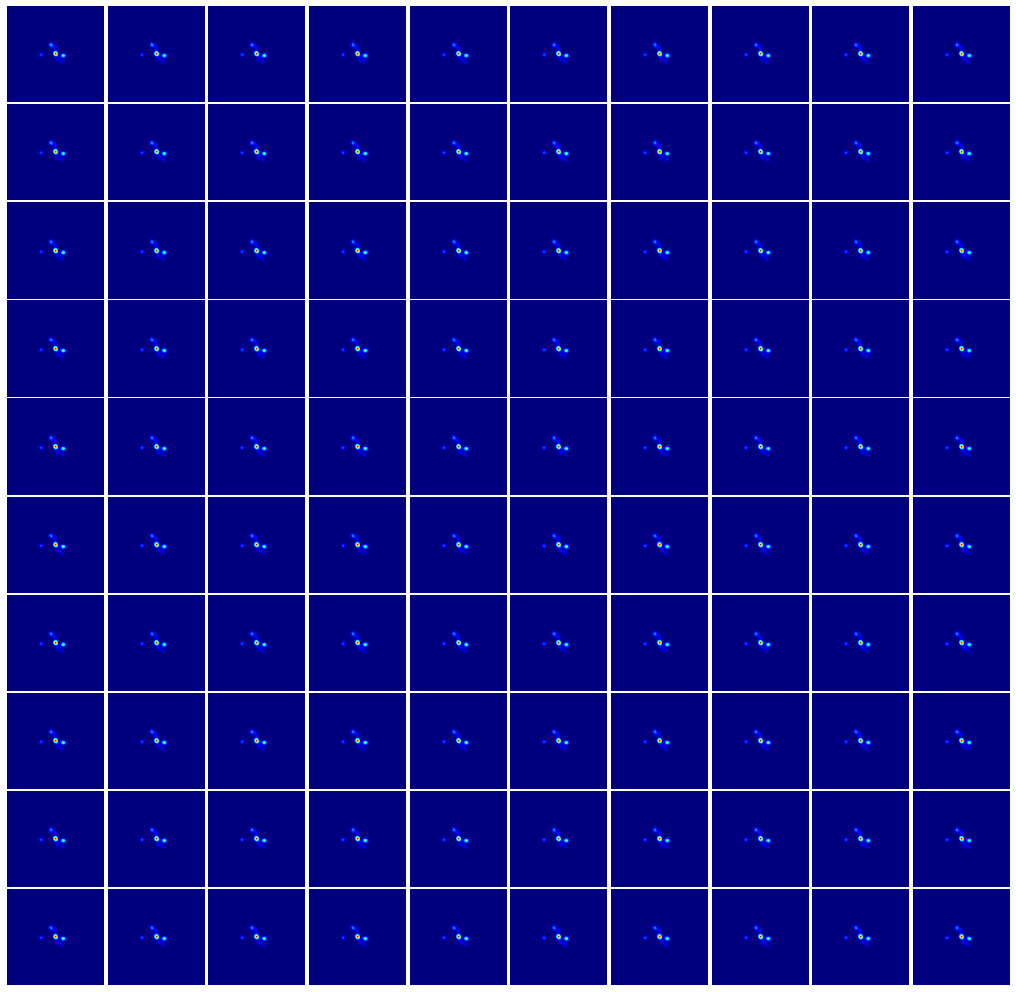

In [22]:
# Grafische Darstellung der SOM
fig, ax = hvis.show_som(som, figsize=(18, 18))

## Map

Das mithilfe der PINK-Executable aus PINK-File und SOM-File erzeugte Map-File beinhaltet das Mapping der Images in den Inputdaten (Pink-File) zu den
Knoten der trainierten SOM.

Mit den Funktionen des `map.py`-Moduls kann die Datei ausgelesen werden und eine *Counting Heatmap* erstellt werden, der das Mapping grafisch dargestellt
etwas einfacher zu entnehmen ist.

In [23]:
from hda_fits import map as hmap

In [24]:
# Header / Metainformationen des Map-Files auslesen
hmap.read_map_file_header("data/my_map_file.map")

MapHeader(version=2, file_type=2, data_type=0, number_of_images=5, data_layout=0, dimensionality=2, som_layout=Layout(width=10, height=10, depth=1), header_end_offset=32)

In [25]:
# Alle Distanzdaten des Mappings des Bildes an Offset 2 lesen
# Bei einem 10x10 SOM-Grid sind dies 10*10 = 100 Distanzwerte
hmap.read_map_file_mapping("data/my_map_file.map", 2)

array([[0.05082934, 0.05082934, 0.05082934, 0.05082934, 0.05082934,
        0.05082934, 0.05082934, 0.05082934, 0.05082934, 0.05082934],
       [0.05082934, 0.05082934, 0.05082934, 0.05082934, 0.05082934,
        0.05082934, 0.05082934, 0.05082934, 0.05082934, 0.05082934],
       [0.05082934, 0.05082934, 0.05082934, 0.05082934, 0.05082934,
        0.05082934, 0.05082934, 0.05082934, 0.05082934, 0.05082934],
       [0.05082934, 0.05082934, 0.05082934, 0.05082934, 0.05082934,
        0.05082934, 0.05082934, 0.05082934, 0.05082934, 0.05082934],
       [0.05082934, 0.05082934, 0.05082934, 0.05082934, 0.05082934,
        0.05082934, 0.05082934, 0.05082934, 0.05082934, 0.05082934],
       [0.05082934, 0.05082934, 0.05082934, 0.05082934, 0.05082934,
        0.05082934, 0.05082934, 0.05082934, 0.05082934, 0.05082934],
       [0.05082934, 0.05082934, 0.05082934, 0.05082934, 0.05082934,
        0.05082934, 0.05082934, 0.05082934, 0.05082934, 0.05082934],
       [0.05082934, 0.05082934, 0.0508293

Mit der Funktion `count_images_per_class("PATH/TO/mapfile.map")` lassen sich die Zuordnungen vorverarbeitet einlesen. Es werden hierdurch zwei
Arrays erzeugt und als Rückgabewerte ausgegeben.

Hierbei stellt das erste Array die Counts per Node dar ie. Index 0 beinhaltet die Anzahl der Bilder, die auf den SOM-Knoten (0,0) gemappt wurden, Index 1, die Anzahl Bilder, die auf SOM-Knoten (0, 1) gemappt
wurden, usw..

Das zweite Array beinhaltet N-Einträge, wobei N der Anzahl Bilder im Eingabe-PINK-File entspricht. Der Index des Arrays korrespondiert zum Bildindex des Pink-Files und die eingetragene Zahl an einem Index
entspricht dem Index des SOM-Knotens, zu dem das Bild die geringst Distanz hat (auf welchen das Bild *gemappt* wurde).

In [26]:
mapped_images_per_node, node_per_image = hmap.count_images_per_class("data/my_map_file.map")

mapped_images_per_node

array([5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [27]:
node_per_image[:5]

[0, 0, 0, 0, 0]

Um das Mapping besser zu veranschaulichen, kann die Count Heatmap des Visualisierungsmoduls genutzt werden


(<Figure size 1080x576 with 2 Axes>, <AxesSubplot:>)

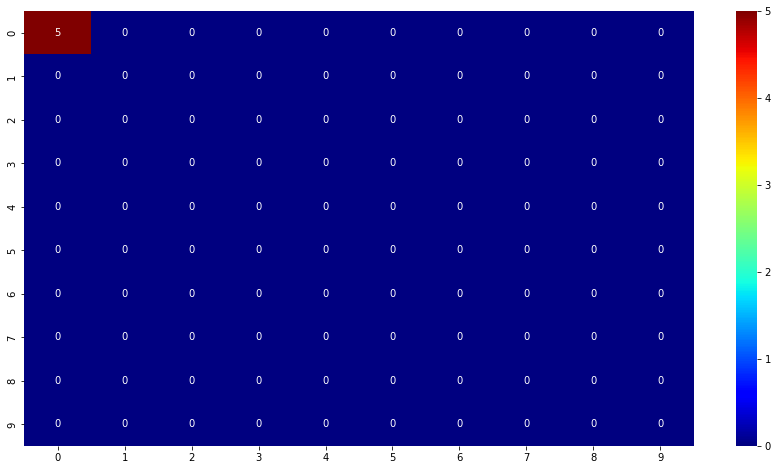

In [28]:
hvis.show_count_heatmap("data/my_map_file.map", figsize=(15,8))